# Requirements

Please make sure the following packages are installed:

- torch
- transformers
- nltk
- scikit-learn
- pandas
- numpy

Install missing libraries by running:

!pip install torch transformers nltk scikit-learn pandas numpy

In [54]:
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import nltk

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Additional Notes
- Download NLTK punkt tokenizer inside the notebook by running: nltk.download('punkt')
- Dataset file "training.1600000.processed.noemoticon.csv" must be placed correctly or uploaded manually. https://www.kaggle.com/datasets/kazanova/sentiment140/data



In [55]:
import zipfile
import os

# Get the uploaded filename
filename = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv (3).zip"

# Unzip it
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("data")


In [56]:
import os

# List files in the unzipped folder
for file in os.listdir("data"):
    print(file)


training.1600000.processed.noemoticon.csv


In [57]:
#checking GPU available or not
if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Reading the datset and displaying it

In [58]:
df =  pd.read_csv("data/training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", header=None , names=['label', 'ids', 'data', 'flag' , 'user','sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 1,600,000



,label,ids,data,flag,user,sentence
1131681,4,1975895789,Sat May 30 16:08:10 PDT 2009,NO_QUERY,erinlynns,About to eat some sloppy meat soon
1480743,4,2066921606,Sun Jun 07 11:25:12 PDT 2009,NO_QUERY,RexMorgan1,wethers turning bbbbaaaadddd!!!!! b'day celebr...
748529,0,2284404311,Mon Jun 22 13:50:37 PDT 2009,NO_QUERY,Souszan,where is my boyfriend
796273,0,2327692681,Thu Jun 25 08:40:06 PDT 2009,NO_QUERY,TheMakeupBird,@peacelovepink09 OMG LUCKYYYY!!! i haven't eve...
442205,0,2067211561,Sun Jun 07 11:57:00 PDT 2009,NO_QUERY,angelsk,"Urm, and I feel sick, why? Not good"
1199520,4,1985330445,Sun May 31 16:53:49 PDT 2009,NO_QUERY,KennethScottH,PHILIP FIX THE CABLE!
715281,0,2259372194,Sat Jun 20 17:28:15 PDT 2009,NO_QUERY,rowyourchelle,my tummy hurts lazy day today!
944902,4,1795855493,Thu May 14 08:29:02 PDT 2009,NO_QUERY,LittlestarRed,@NKOTB Hope You do know when You'll be back ag...
577494,0,2212575770,Wed Jun 17 14:15:59 PDT 2009,NO_QUERY,Crazyharry77,Why do I have to install 8.2 all I want is 3.0...
199675,0,1971493426,Sat May 30 07:14:26 PDT 2009,NO_QUERY,Jantunstill,Just broke my bracelet


Displaying labels

In [59]:
print(df['label'].unique())


[0 4]


Holding required features for training model

In [60]:
df = df[['label' ,'sentence']]
df = df.copy()
df['label'] = df['label'].replace({0: 0, 4: 1})
df

,label,sentence
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [61]:
#DISPLAIYNG COUNT OF EACH LABEL
label_counts = df['label'].value_counts()
print(label_counts)

label
0    800000
1    800000
Name: count, dtype: int64


In [62]:
# INTSALL THRE EMOJI MOUDULE USED IN THE DATA PREPROCESSING
!pip install emoji


Preprocessing

In [63]:
import re
from emoji import demojize

def preprocess_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'@\w+', '', text)  # remove @mentions
    text = re.sub(r'#', '', text)  # remove hashtags
    text = demojize(text)  # convert emojis to text
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

#read cleaned datatset

In [64]:
#APPLYING THE PREPROCESSING
df['clened text'] = df['sentence'].apply(preprocess_tweet)

In [65]:
df.head()

,label,sentence,clened text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",- a that's a bummer. you shoulda got david car...
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to sa...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am ..."


In [66]:
#DISPLAYING THE UNIQUE LABELS AGAIN
print(df['label'].unique())

[0 1]


In [67]:
#REMPOVING NULL VALUES
# Drop rows where "clened text" is NaN
df = df.dropna(subset=["clened text"])

Sampiling data

In [68]:
# Randomly sample 50,000 rows from ORGINAL DATASET
df_small = df.sample(n=50000, random_state=42)
df=df_small

Displaying labels

In [69]:
#DIAPLAYING COUNTS OF EACH UNIQUE LABEL
label_counts = df['label'].value_counts()
print(label_counts)

label
1    25014
0    24986
Name: count, dtype: int64


<ipython-input-70-30bad6d5a18f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=label_counts.values, palette="Blues_d")


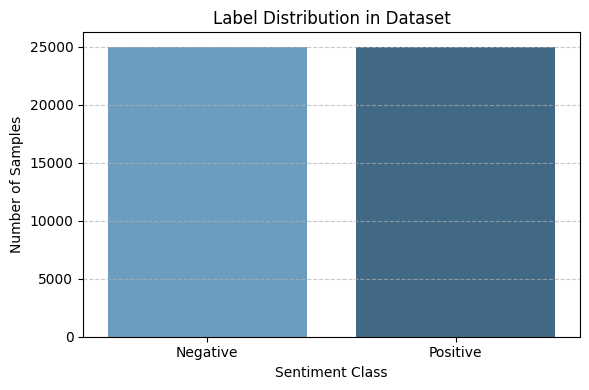

In [70]:
#VISUALIZING EACH NAUMBER OF SAMPLES PRESNT BASED ON LABELS
import matplotlib.pyplot as plt
import seaborn as sns

# Count labels
label_counts = df['label'].value_counts().sort_index()

# Label mapping if needed
label_names = {0: "Negative", 1: "Positive"}

# Convert index to label names for display
labels = [label_names[i] for i in label_counts.index]

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=label_counts.values, palette="Blues_d")
plt.title("Label Distribution in Dataset")
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [71]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Tokenization

In [72]:
tokenized_texts = [word_tokenize(text) for text in df["clened text"]]

# Build vocab
word_counts = Counter(word for sent in tokenized_texts for word in sent)
vocab = {word: i + 2 for i, (word, _) in enumerate(word_counts.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1


BULDING VOCABLARY FOR THE LSTM MODEL

In [73]:
def encode(sentence, vocab):
    return [vocab.get(word, vocab["<UNK>"]) for word in sentence]

encoded = [torch.tensor(encode(sent, vocab)) for sent in tokenized_texts]
padded = pad_sequence(encoded, batch_first=True, padding_value=vocab["<PAD>"])
labels = torch.tensor(df["label"].values)


SPLITTING DATA FOR TRAINNG VALIDATING AND TESTING (80,10,10)

In [74]:
# First split 90% train+val and 10% test
X_temp, X_test, y_temp, y_test = train_test_split(padded, labels, test_size=0.1, random_state=42)

# Then split 80% train and 10% val from the 90%
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.111, random_state=42)


DEFINE DATALOADER

In [75]:
class TweetDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

train_dataset = TweetDataset(X_train, y_train)
val_dataset = TweetDataset(X_val, y_val)
test_dataset = TweetDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


BASELINE MODELS

In [76]:
import random
from collections import Counter
#random baseline
def random_baseline(y_test):
    y_test = list(y_test)  # In case it's Tensor
    random_preds = [random.choice([0, 1]) for _ in range(len(y_test))]
    return random_preds

#Most frequent Baseline

def most_frequent_baseline(train_labels, test_labels):
    most_common_label = Counter(train_labels).most_common(1)[0][0]
    frequent_preds = [most_common_label for _ in range(len(test_labels))]
    return frequent_preds


DISPLAYING ACCURACIES OF THE BASE LINE MODELS RANDOM BASELINE AND MOST FREQUENT BASELINE

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Random Baseline
random_preds = random_baseline(y_test)
print("Random Baseline Accuracy:", accuracy_score(y_test, random_preds))
print("Random Baseline Precision:", precision_score(y_test, random_preds))
print("Random Baseline Recall:", recall_score(y_test, random_preds))
print("Random Baseline F1-Score:", f1_score(y_test, random_preds))

# Most Frequent Baseline
frequent_preds = most_frequent_baseline(y_train, y_test)
print("Most Frequent Baseline Accuracy:", accuracy_score(y_test, frequent_preds))
print("Most Frequent Baseline Precision:", precision_score(y_test, frequent_preds))
print("Most Frequent Baseline Recall:", recall_score(y_test, frequent_preds))
print("Most Frequent Baseline F1-Score:", f1_score(y_test, frequent_preds))


Random Baseline Accuracy: 0.5018
Random Baseline Precision: 0.5087576374745417
Random Baseline Recall: 0.4928966061562747
Random Baseline F1-Score: 0.50070154339547
Most Frequent Baseline Accuracy: 0.4932


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Most Frequent Baseline Precision: 0.0
Most Frequent Baseline Recall: 0.0
Most Frequent Baseline F1-Score: 0.0


## Model Setup

We initialize the baseline model (Custom Bi-LSTM) for sentiment classification.

- **Device Selection:** The model will automatically run on GPU if available (`cuda`), otherwise it will run on CPU.
- **Model Architecture:** The `CustomLSTM` model is instantiated with:
  - Vocabulary size based on the size of the constructed vocabulary
  - Embedding dimension = 100
  - Hidden dimension = 128
  - Output dimension = 2 (Positive/Negative)
  depending on the dataset label format
  - 2 LSTM layers
  - 50% Dropout rate to prevent overfitting
- **Loss Function:** CrossEntropyLoss is used for multi-class classification.
- **Optimizer:** The Adam optimizer is used with a learning rate of 0.001 for efficient training.


BILSTM

In [78]:
class CustomLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super(CustomLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        # Get the final forward and backward hidden states
        forward = lstm_out[:, -1, :self.lstm.hidden_size]
        backward = lstm_out[:, 0, self.lstm.hidden_size:]
        hidden = torch.cat((forward, backward), dim=1)
        output = self.fc(self.dropout(hidden))
        return output


In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomLSTM(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=128,
    output_dim=2,  # 2 classes: positive, negative
    n_layers=2,
    dropout=0.5
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


CODE FOR TRAINING  BILSTM

In [80]:
def train(model, loader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    accuracy = correct / total
    return epoch_loss / len(loader), accuracy


EVALUATING

In [81]:
def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            epoch_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return epoch_loss / len(loader), accuracy


TRAINING THE MODEL

In [82]:
best_val_acc = 0.0
best_model_state = None

EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("-" * 40)

    # Save model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()  # Save the model parameters

# After all epochs, load the best model
model.load_state_dict(best_model_state)

# Save the best model to a file (optional)
torch.save(model.state_dict(), "best_lstm_model.pth")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Epoch 1/5
Train Loss: 0.5768 | Train Acc: 0.6956
Val   Loss: 0.5187 | Val   Acc: 0.7415
----------------------------------------
Epoch 2/5
Train Loss: 0.4610 | Train Acc: 0.7846
Val   Loss: 0.4802 | Val   Acc: 0.7660
----------------------------------------
Epoch 3/5
Train Loss: 0.3838 | Train Acc: 0.8287
Val   Loss: 0.4879 | Val   Acc: 0.7690
----------------------------------------
Epoch 4/5
Train Loss: 0.3107 | Train Acc: 0.8691
Val   Loss: 0.5346 | Val   Acc: 0.7584
----------------------------------------
Epoch 5/5
Train Loss: 0.2402 | Train Acc: 0.9022
Val   Loss: 0.5993 | Val   Acc: 0.7684
----------------------------------------
Best Validation Accuracy: 0.7690


CONFUSION MATRIX

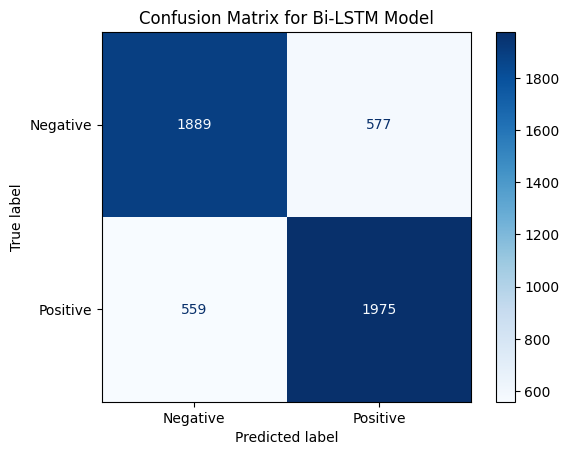

In [83]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


model.eval()

y_true = []
y_pred = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Bi-LSTM Model")
plt.savefig("lstm_confusion_matrix.png")  # Save figure
plt.show()


In [84]:
test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Loss: 0.5887
Final Test Accuracy: 0.7728


IMPORTING REQUIRED MODULES FOR BERT

In [85]:
from transformers import AutoTokenizer, AutoModel


In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')


PROPOSED BERT MODEL , EVALUATION AND RESULTS

## Fine-tuning BERT Model

We fine-tune a pre-trained `bert-base-uncased` model from Huggingface Transformers library for sentiment classification.

### Steps:
- **Tokenization:**  
  The input text is tokenized using `AutoTokenizer` with padding and truncation to a maximum length of 128 tokens.

- **Dataset and Dataloaders:**  
  A custom `BERTTweetDataset` class is defined to handle input IDs, attention masks, and labels.  
  The dataset is split into training (80%), validation (10%), and test (10%) sets, and loaded into batches using `DataLoader`.

- **Model Architecture:**  
  A custom `CustomBERTClassifier` class wraps the BERT encoder followed by:
  - A dropout layer for regularization
  - A fully connected layer (768 ➔ 256)
  - ReLU activation
  - A second dropout layer
  - A final fully connected layer projecting into the number of output classes (2 or 3 depending on labeling)

- **Training and Evaluation:**  
  We use CrossEntropyLoss as the loss function and Adam optimizer with a learning rate of 2e-5.  
  The model is trained for 3 epochs, and the best model (based on validation accuracy) is saved.

- **Testing:**  
  After training, the best model is loaded and evaluated on the test set. Final loss and accuracy are reported.


In [88]:

# Tokenization
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
encoded_inputs = tokenizer(
    list(df["clened text"]),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]
labels = torch.tensor(df["label"].values)

# Dataset Class
class BERTTweetDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

# Train/Val/Test Split
X_temp_ids, X_test_ids, X_temp_mask, X_test_mask, y_temp, y_test = train_test_split(
    input_ids, attention_mask, labels, test_size=0.1, random_state=42)

X_train_ids, X_val_ids, X_train_mask, X_val_mask, y_train, y_val = train_test_split(
    X_temp_ids, X_temp_mask, y_temp, test_size=0.111, random_state=42)

train_dataset = BERTTweetDataset(X_train_ids, X_train_mask, y_train)
val_dataset = BERTTweetDataset(X_val_ids, X_val_mask, y_val)
test_dataset = BERTTweetDataset(X_test_ids, X_test_mask, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Custom BERT Model
class CustomBERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(CustomBERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_model = AutoModel.from_pretrained('bert-base-uncased')
model = CustomBERTClassifier(bert_model=bert_model, num_classes=3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Train and Evaluate Functions
def train(model, loader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    return epoch_loss / len(loader), correct / total

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, targets)

            epoch_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    return epoch_loss / len(loader), correct / total

# Train Loop with Best Model Saving
best_val_acc = 0.0
best_model_state = None
EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("-" * 40)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

# Load Best Model
model.load_state_dict(best_model_state)
torch.save(model.state_dict(), "best_bert_model.pth")

# Final Test Evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


Epoch 1/3
Train Loss: 0.4701 | Train Acc: 0.7935
Val   Loss: 0.3828 | Val   Acc: 0.8314
----------------------------------------
Epoch 2/3
Train Loss: 0.3254 | Train Acc: 0.8677
Val   Loss: 0.3834 | Val   Acc: 0.8306
----------------------------------------
Epoch 3/3
Train Loss: 0.2264 | Train Acc: 0.9156
Val   Loss: 0.3985 | Val   Acc: 0.8274
----------------------------------------
Final Test Loss: 0.3972
Final Test Accuracy: 0.8330


In [89]:
from sklearn.metrics import classification_report

# Collect all predictions and true labels
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Print classification report
print(classification_report(all_targets, all_preds, digits=4, target_names=["Negative", "Positive"]))


              precision    recall  f1-score   support

    Negative     0.8227    0.8431    0.8328      2466
    Positive     0.8435    0.8232    0.8332      2534

    accuracy                         0.8330      5000
   macro avg     0.8331    0.8331    0.8330      5000
weighted avg     0.8333    0.8330    0.8330      5000



Results

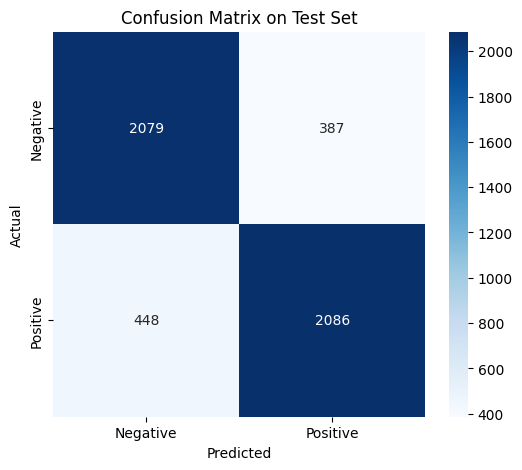

In [90]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative","Positive"],
            yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()


## Conclusion

In this project, we evaluated both traditional baseline models and deep learning-based approaches for sentiment classification on the Sentiment140 dataset.

The baseline models performed as follows:
- **Random Baseline** achieved an accuracy of approximately **50.18%**, which is expected for random guessing between two classes.
- **Most Frequent Baseline** achieved an accuracy of **49.32%**, simply predicting the most common label. However, it resulted in a precision, recall, and F1-score of **0**, highlighting its inability to correctly predict minority class samples.

Our proposed models demonstrated significant improvements:
- **Bi-LSTM Model (Baseline Deep Learning Model)** achieved a test accuracy of approximately **77%**, successfully learning sequential dependencies in the text data.
- **Fine-tuned BERT Model (Proposed Advanced Model)** further improved performance with a test accuracy of approximately **83%**, demonstrating the effectiveness of transformer architectures and pre-training on large corpora.

The results clearly show that while simple baselines provide a reference point, deep learning models — particularly pre-trained transformers like BERT — significantly outperform them in terms of all evaluation metrics. Thus, fine-tuning transformer models remains a highly effective approach for sentiment analysis tasks, especially when dealing with noisy and informal social media text.
